# Семинар "Свёрточные нейронные сети на Pytorch"

# Cвёрточные нейронные сети

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision


def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    
def show_grayscale_image(image, figsize=(16, 9)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Создадим свертку
## Вход: 1 канал
## Выход: 1 канал
## Размер ядра: 3х3

In [2]:
layer = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3))

In [3]:
layer.weight

Parameter containing:
tensor([[[[-0.2104, -0.1956,  0.2356],
          [ 0.2644, -0.2959,  0.0069],
          [ 0.0974,  0.1089, -0.1758]]]], requires_grad=True)

In [4]:
layer.weight.shape

torch.Size([1, 1, 3, 3])

# Модифицируем вес 
### вес доступен через .weight.data

In [5]:
# измените вес так, чтобы все 9 параметров были одинаковыми и в сумме давали единицу
layer.weight.data = torch.ones_like(layer.weight.data)
layer.weight.data /= layer.weight.data.sum()

In [6]:
layer.weight.data

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])

In [7]:
layer.bias

Parameter containing:
tensor([-0.1482], requires_grad=True)

### что будет делать такая свертка?

In [8]:
input_tensor = torch.arange(9).reshape(1, 1, 3, 3)
# если размер будет не (1, 1, 3, 3), а, например, (1, 3, 3), то получим
#RuntimeError: Expected 4-dimensional input for 4-dimensional weight [1, 1, 3, 3], but got 3-dimensional input of size [1, 3, 3] instead

In [9]:
input_tensor.shape

torch.Size([1, 1, 3, 3])

In [10]:
input_tensor

tensor([[[[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]]]])

In [11]:
# получите тензор на выходе из свертоного слоя
output_tensor = layer(input_tensor.float())

In [12]:
output_tensor

tensor([[[[3.8518]]]], grad_fn=<ThnnConv2DBackward>)

# Почему получился такой результат?

In [13]:
layer.bias.data

tensor([-0.1482])

In [14]:
# преобразуйте bias сети
layer.bias.data = torch.zeros_like(layer.bias.data)

In [15]:
# layer.eval()
layer.train()

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [16]:
layer.weight.grad

In [17]:
input_tensor = torch.arange(9).reshape(1, 1, 3, 3)

In [18]:
input_tensor.shape

torch.Size([1, 1, 3, 3])

In [19]:
input_tensor

tensor([[[[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]]]])

In [20]:
output_tensor = layer(input_tensor.float())

In [21]:
output_tensor

tensor([[[[4.]]]], grad_fn=<ThnnConv2DBackward>)

## Кастомные ядра свёртки

In [22]:
path = './data/photos/lecun.jpeg'

In [23]:
# прочитайте изображение и переведите его в grayscale

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [24]:
assert img.shape == (3960, 2640)

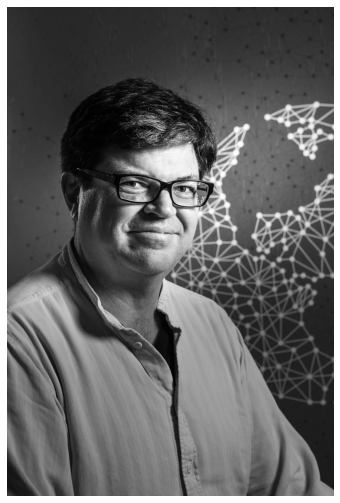

In [25]:
show_grayscale_image(img)

In [26]:
to_tensor = torchvision.transforms.ToTensor()

In [27]:
img_tensor = to_tensor(img)

In [28]:
img_tensor.shape

torch.Size([1, 3960, 2640])

In [29]:
# сделаейте так, чтобы assert в следующей строчке прошел. hind: unsqueeze

img_tensor = img_tensor.unsqueeze(0)

In [30]:
assert img_tensor.shape == torch.Size([1, 1, 3960, 2640])

## Создадим свертку, которая размоет изображение

In [31]:
kernel_size = 50
layer = torch.nn.Conv2d(1, 1, kernel_size=kernel_size)

In [32]:
# обновите веса так, чтобы получилась свертка, которая размывает изображение

layer.weight.data = torch.ones_like(layer.weight.data)
layer.weight.data /= layer.weight.data.sum()
layer.bias.data = torch.zeros_like(layer.bias.data)

In [33]:
layer.weight.data

tensor([[[[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          ...,
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]]]])

In [34]:
layer.eval()

Conv2d(1, 1, kernel_size=(50, 50), stride=(1, 1))

In [35]:
output_tensor = layer(img_tensor)

In [36]:
output_tensor.shape

torch.Size([1, 1, 3911, 2591])

In [37]:
import torchvision.transforms as transforms

# функция, переводящее тензор в PIL-изображение
to_pil_image = transforms.ToPILImage()

In [38]:
output_img = to_pil_image(output_tensor.squeeze(0))

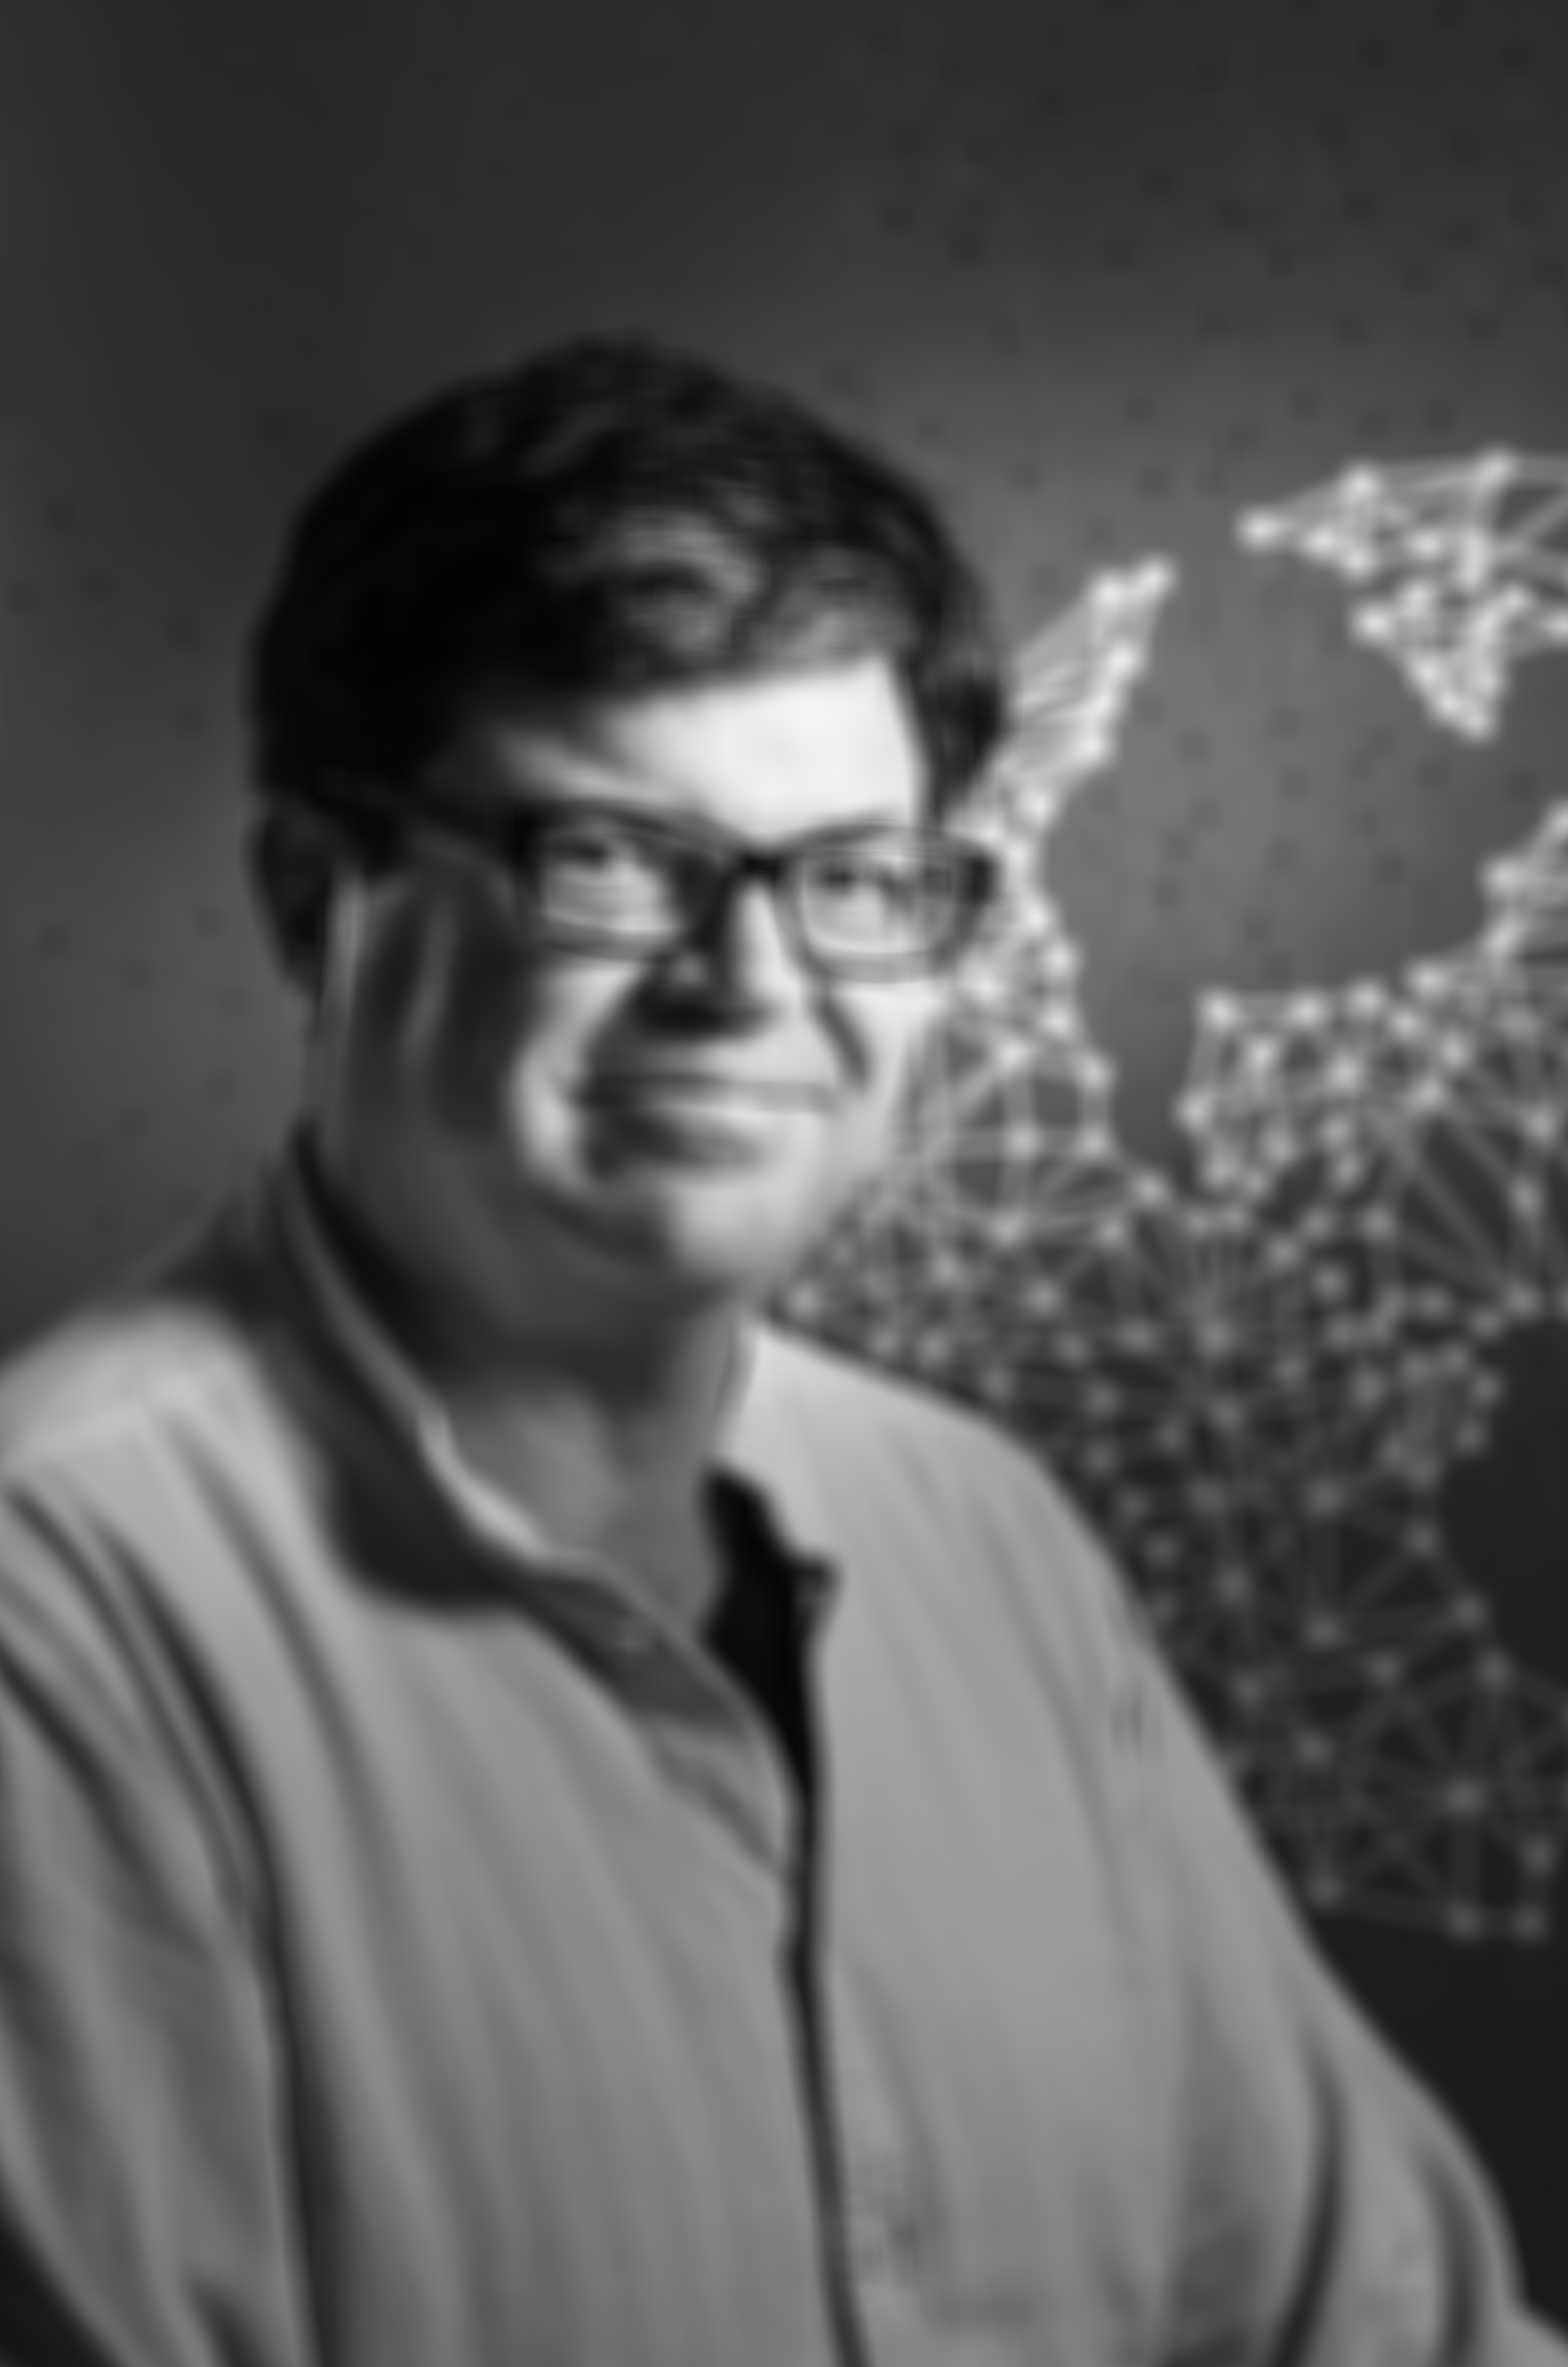

In [39]:
output_img

# Обучие моделей на изображениях

## Данные, преобразования

In [40]:
import torch
import torchvision
import torchvision.transforms as transforms

In [41]:
# задайте последовательность трансформаций, переводящих изображение в тензор и нормирующих его.
# hint: transforms.Compose, transforms.ToTensor(), transforms.Normalize

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [42]:
batch_size = 4

# dataset задаёт данные
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# dataloader подгружает их
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Отрисовка

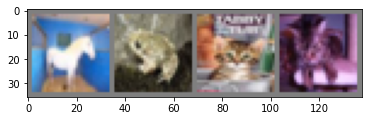

horse  frog  cat  cat


In [43]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5 # убираем нормализацию
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# взять случайный батч изображений
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('  '.join('{}'.format(classes[labels[j]]) for j in range(4)))

## Рутина обучения модели

In [44]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            
            output = net(inputs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('Epoch {0}/{1}, iteration {2}, loss: {3:.3f}'.format(epoch + 1, num_epochs, i + 1, 
                                                                          running_loss / 2000))
                running_loss = 0.0
        print()

    print('Finished Training')
    
    return net

## Точность модели на тестовом сете

In [45]:
def all_accuracy(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            predicted = net(images).argmax(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(
        100 * correct / total))

In [46]:
def class_accuracy(net, testloader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of {} : {} %'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))

## Полносвязная сеть для классификации

In [47]:
import torch.nn as nn
import torch.nn.functional as F

# созлайте сеть, состоящую из 3-х полносвязных слоёв (input_size -> 128, 128 -> 32, 32 -> output_size) 
# и испрользовала в качестве активции ReLU

class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = FeedForwardNet()

In [48]:
import torch.optim as optim

# дополните код: инициализируйте критерий и оптимизатор (используйте SGD с моментумом)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [49]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

Epoch 1/5, iteration 2000, loss: 1.961


KeyboardInterrupt: 

In [ ]:
all_accuracy(net, testloader)

In [ ]:
class_accuracy(net, testloader)

## Свёрточная сеть для классификации

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

In [ ]:
# сохраним сеть
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('{}'.format(classes[labels[j]]) for j in range(batch_size)))

In [ ]:
# загрузим сеть
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('{}'.format(classes[predicted[j]]) for j in range(4)))

In [ ]:
all_accuracy(net, testloader)

In [ ]:
class_accuracy(net, testloader)

### Managing cuda

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)

# Текстовая версия части этого семинара доступна на официальном сайте pytorch:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html